# Importing tools

**Dataset download link --> https://www.kaggle.com/c/aptos2019-blindness-detection**

**NOTE: We have 3662 train images but we only choose 1200 images because of insufficient memory.**

In [1]:
import os
import glob
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import gc
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'aptos2019-blindness-detection',
 'aptos2019-blindness-detection.zip',
 'CLAHE.png',
 'saved_model',
 'Tensorflow Blindless Detection.ipynb']

In [3]:
CLASSES = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

# Read .csv files

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

In [4]:
DATA_DIR = "aptos2019-blindness-detection/"
TRAIN_DIR = os.path.join(DATA_DIR,"train_images")
TEST_DIR = os.path.join(DATA_DIR,"test_images")
TRAIN_CSV = os.path.join(DATA_DIR,"train.csv")

df_train = pd.read_csv(TRAIN_CSV,sep=",")[:1200]
df_train

id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
1195  5299a532f0e0          0
1196  52ae917fcea4          1
1197  52dbec057cc8          2
1198  52ddde91a349          0
1199  52edbe29d655          0

[1200 rows x 2 columns]

In [5]:
df_train = df_train.sort_values(by=['id_code'])
df_train

id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
1195  5299a532f0e0          0
1196  52ae917fcea4          1
1197  52dbec057cc8          2
1198  52ddde91a349          0
1199  52edbe29d655          0

[1200 rows x 2 columns]

<AxesSubplot: xlabel='diagnosis', ylabel='count'>

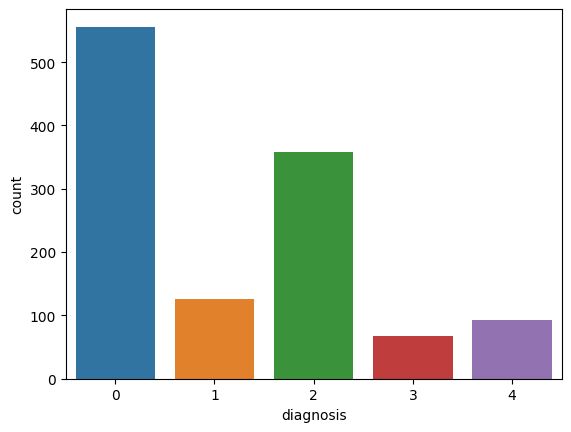

In [6]:
sns.countplot(x='diagnosis',data=df_train)

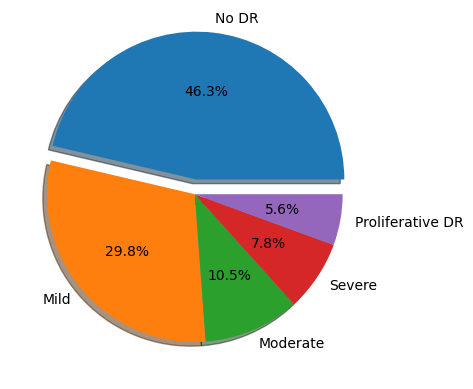

In [7]:
explode = (0.1, 0, 0, 0,0)

plt.pie(df_train['diagnosis'].value_counts(),
        autopct="%1.1f%%",labels=CLASSES.values(),
       explode = explode,shadow=True);

# Read images

In [8]:
TRAIN_IMG_PATHS = glob.glob(TRAIN_DIR+"/*")[:1200]
TRAIN_IMG_PATHS[:10]

['aptos2019-blindness-detection/train_images\\000c1434d8d7.png',
 'aptos2019-blindness-detection/train_images\\001639a390f0.png',
 'aptos2019-blindness-detection/train_images\\0024cdab0c1e.png',
 'aptos2019-blindness-detection/train_images\\002c21358ce6.png',
 'aptos2019-blindness-detection/train_images\\005b95c28852.png',
 'aptos2019-blindness-detection/train_images\\0083ee8054ee.png',
 'aptos2019-blindness-detection/train_images\\0097f532ac9f.png',
 'aptos2019-blindness-detection/train_images\\00a8624548a9.png',
 'aptos2019-blindness-detection/train_images\\00b74780d31d.png',
 'aptos2019-blindness-detection/train_images\\00cb6555d108.png']

In [9]:
len(TRAIN_IMG_PATHS)

1200

In [10]:
from tqdm import tqdm_notebook as tqdm

def load_images(paths,size):
    images = []
    for p in tqdm(paths[:size]):
        # Read the image from path
        img = cv2.imread(p)
        # Resize the image
        img = cv2.resize(img,(400,400))
        # Convert color to RGB
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
    images = np.array(images)
    return images

In [11]:
TRAIN_IMAGES = load_images(TRAIN_IMG_PATHS,size=1200)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [12]:
TRAIN_IMAGES.shape

(1200, 400, 400, 3)

# Display images

In [13]:
import random

def display_instances(paths,df,classes,row,col):
    plt.figure(figsize=(14,12))
    size = row*col
    rand_paths = []
    rand_nums = np.random.randint(low=0,high=len(paths)-1,size=size)
    
    for i in rand_nums:
        p = paths[i]
        rand_paths.append(p)
    for i in range(size):
        
        id_code = rand_paths[i].split(".")[0][-12:]
        label_num = df['diagnosis'][df['id_code']==id_code].iloc[0]
        label = classes[label_num]
        
        plt.subplot(row,col,i+1)
        
        img = cv2.imread(rand_paths[i])
        img = cv2.resize(img,(400,400))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
         
        
        plt.imshow(img)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        

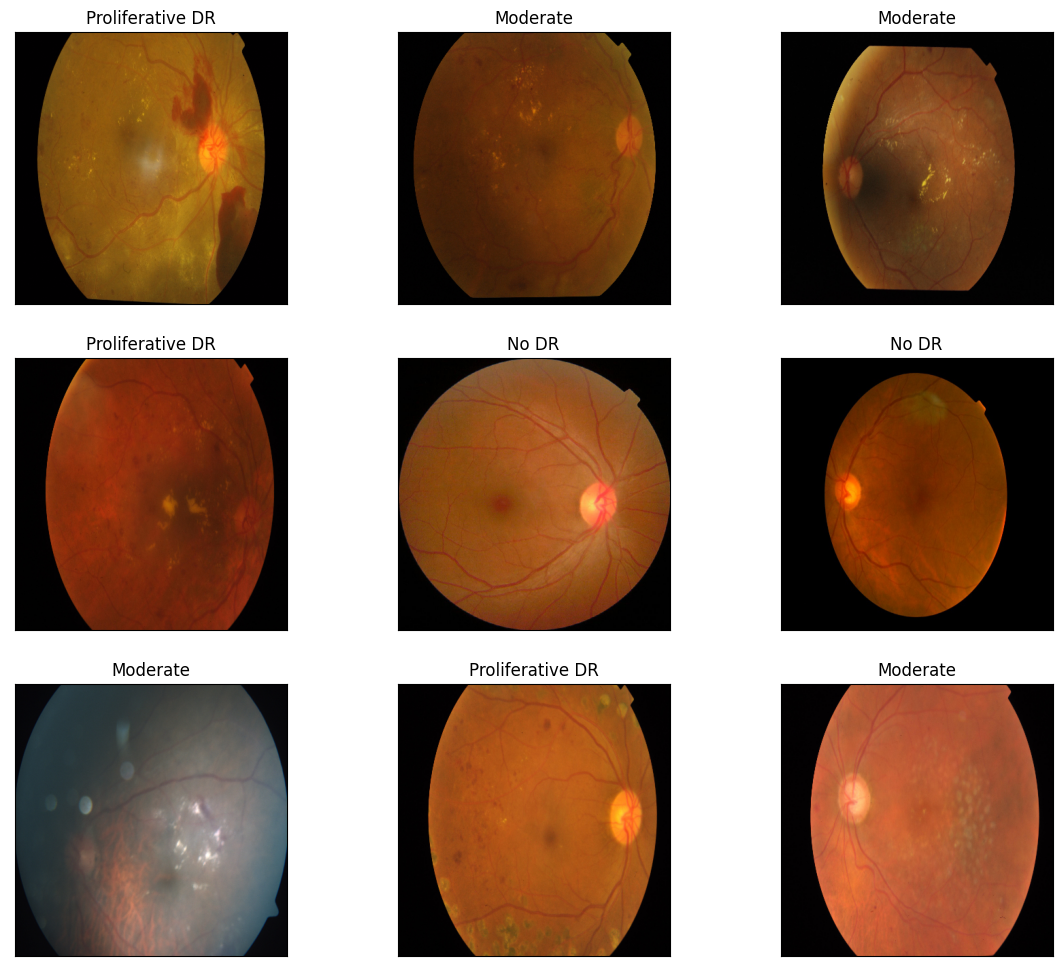

In [14]:
display_instances(TRAIN_IMG_PATHS,df_train,CLASSES,3,3)

# Image preprocessing(Demo)

**Firstly,we crop all images.To apply cropping,we need the contour of images.After that,we'll find the coordinates of the contours and crop the images.**


Text(0.5, 1.0, 'Binary Thresh')

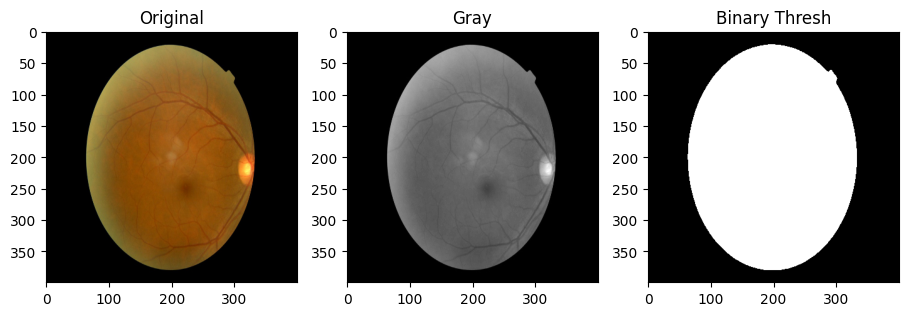

In [15]:
# Choose random image
im = TRAIN_IMAGES[77]
im_copy = im.copy()

plt.figure(figsize=(11,11))

plt.subplot(1,3,1)
plt.imshow(im_copy)
plt.title("Original")

plt.subplot(1,3,2)
gray_copy = cv2.cvtColor(im_copy,cv2.COLOR_RGB2GRAY)
plt.imshow(gray_copy,cmap="gray") 
plt.title("Gray")

plt.subplot(1,3,3)
_,thresh_copy = cv2.threshold(gray_copy,10,255,cv2.THRESH_BINARY)
plt.imshow(thresh_copy,cmap="gray") 
plt.title("Binary Thresh")

## 1 - Converting image to gray

(400, 400)

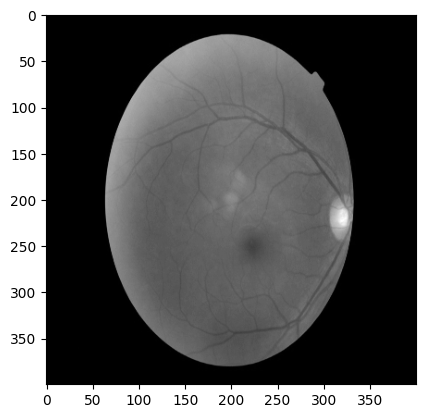

In [16]:
gray_im = cv2.cvtColor(im_copy,cv2.COLOR_RGB2GRAY)
plt.imshow(gray_im,cmap='gray')
gray_im.shape

## 2 - Applying Gaussian Blur

**To clear the noises,we'll apply Gaussian Blur technique.**

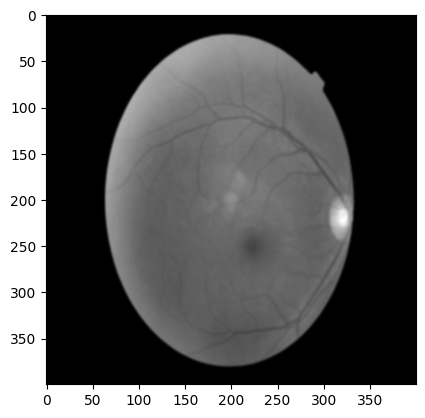

In [17]:
blur_im = cv2.GaussianBlur(gray_im,(5,5),0)
plt.imshow(blur_im,cmap='gray')

# 3 - Thresh the image

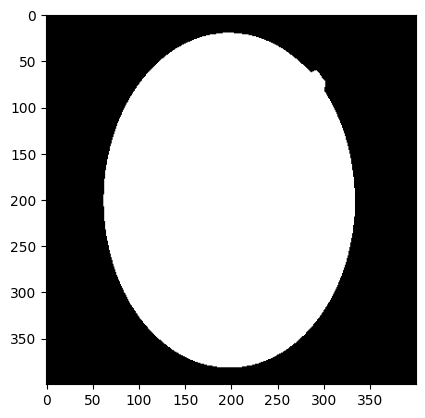

In [18]:
_,thresh = cv2.threshold(blur_im,10,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')

# 4 - Find contours

**To crop the image,we'll find the contours of thresh image.After that,we'll find the maximum and minimum coordinates on x and y-axis.**

In [19]:
contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours     # Contours is a type of tuple

((array([[[191,  20]],
  
         [[190,  21]],
  
         [[189,  21]],
  
         ...,
  
         [[194,  20]],
  
         [[193,  20]],
  
         [[192,  20]]], dtype=int32),),
 array([[[-1, -1, -1, -1]]], dtype=int32))

**Contours are a type of tuple.To seperate from tuple,we'll slice the tuple.**

In [20]:
contours = contours[0][0]
contours

array([[[191,  20]],

       [[190,  21]],

       [[189,  21]],

       ...,

       [[194,  20]],

       [[193,  20]],

       [[192,  20]]], dtype=int32)

In [21]:
contours.shape

(912, 1, 2)

**Contours shape is (912, 1, 2).We'll reduce the dimension to (912,2).**

In [22]:
contours = contours[:,0,:]
contours.shape

(912, 2)

# 5 - Find the boundary coordinates

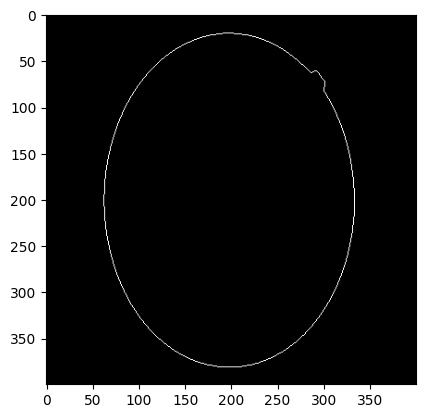

In [23]:
x_coords = contours[:,0]
y_coords = contours[:,1]

mask = np.zeros((400,400),dtype=np.uint8)

mask[y_coords,x_coords]=1

plt.imshow(mask,cmap='gray')


In [24]:
x_coords.argmax()

654

In [25]:
x_coords[654]

333

In [26]:
x_max_idx = x_coords.argmax()
x_max = (x_coords[x_max_idx],y_coords[x_max_idx])

x_min_idx = x_coords.argmin()
x_min = (x_coords[x_min_idx],y_coords[x_min_idx])

y_max_idx = y_coords.argmax()
y_max = (x_coords[y_max_idx],y_coords[y_max_idx])

y_min_idx = y_coords.argmin()
y_min = (x_coords[y_min_idx],y_coords[y_min_idx])

Text(191, 80, 'y_min \n(191, 20)')

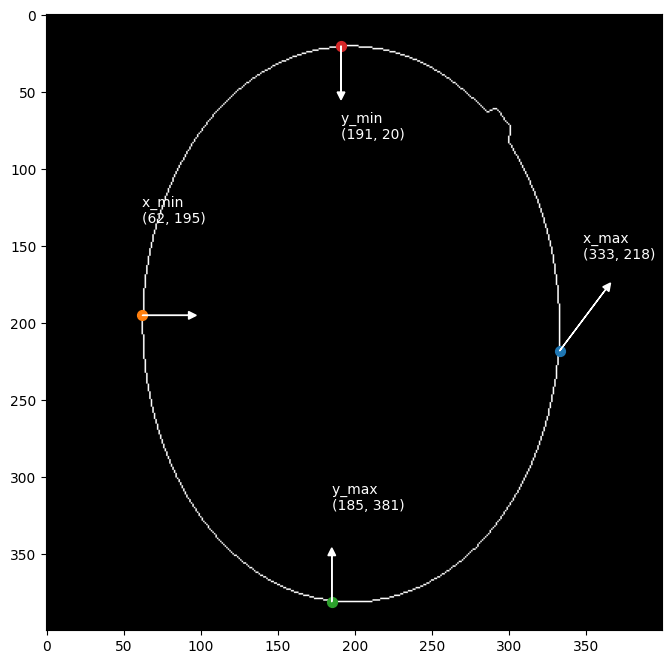

In [27]:
plt.figure(figsize=(8,8))

plt.imshow(mask,cmap='gray')
plt.scatter(x_max[0],x_max[1],s=50)
plt.scatter(x_min[0],x_min[1],s=50)
plt.scatter(y_max[0],y_max[1],s=50)
plt.scatter(y_min[0],y_min[1],s=50)

plt.arrow(x_max[0],x_max[1],30,-40,color='w',
          head_length=5,width=0.1,head_width=5)
plt.text(x_max[0]+15,x_max[1]-60,s=f"x_max \n{x_max[0],x_max[1]}",color='w')

plt.arrow(x_min[0],x_min[1],30,0,color='w',
          head_length=5,width=0.1,head_width=5)
plt.text(x_min[0],x_min[1]-60,s=f"x_min \n{x_min[0],x_min[1]}",color='w')

plt.arrow(y_max[0],y_max[1],0,-30,color='w',
          head_length=5,width=0.1,head_width=5)
plt.text(y_max[0],y_max[1]-60,s=f"y_max \n{y_max[0],y_max[1]}",color='w')

plt.arrow(y_min[0],y_min[1],0,30,color='w',
          head_length=5,width=0.1,head_width=5)
plt.text(y_min[0],y_min[1]+60,s=f"y_min \n{y_min[0],y_min[1]}",color='w')

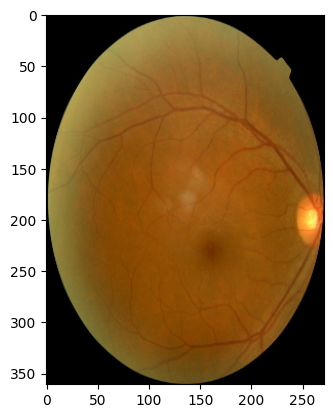

In [28]:
crop_im = im_copy[y_min[1]:y_max[1],x_min[0]:x_max[0]]
plt.imshow(crop_im)

# 6 - Contrast limited adaptive histogram equalization(CLAHE)

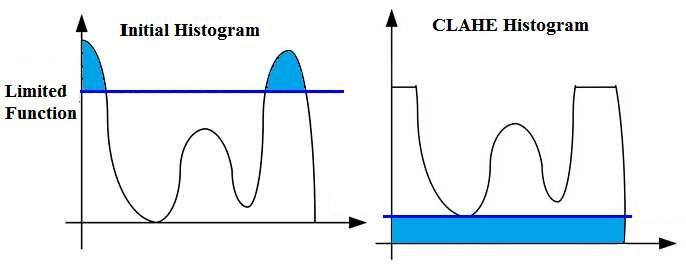

**To get more accurate results,we'll adjust the contrast of the image by using CLAHE,which is better distrubition of image pixel values.**

**We will use CLAHE instead of Histogram Equalization because Histogram Equalization causes the noises on image.**

**To adjust the contrast , we need LAB color space to access lightness(L).**

(361, 271, 3)


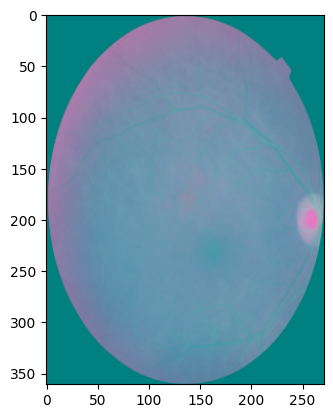

In [29]:
im_lab = cv2.cvtColor(crop_im,cv2.COLOR_RGB2LAB)
print(im_lab.shape)
plt.imshow(im_lab)

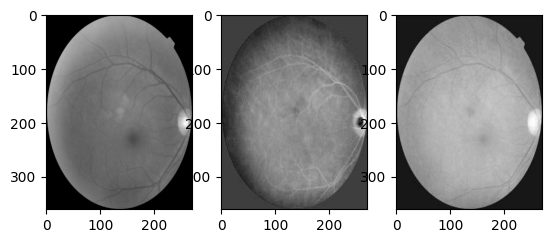

In [30]:
# Split channels

l,a,b = cv2.split(im_lab)
plt.subplot(1,3,1)
plt.imshow(l,cmap='gray')

plt.subplot(1,3,2)
plt.imshow(a,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(b,cmap='gray')

(array([21703.,   163.,   249., 13824., 47272.,  9664.,  4543.,   216.,
          113.,    84.]),
 array([  0. ,  24.7,  49.4,  74.1,  98.8, 123.5, 148.2, 172.9, 197.6,
        222.3, 247. ]),
 <BarContainer object of 10 artists>)

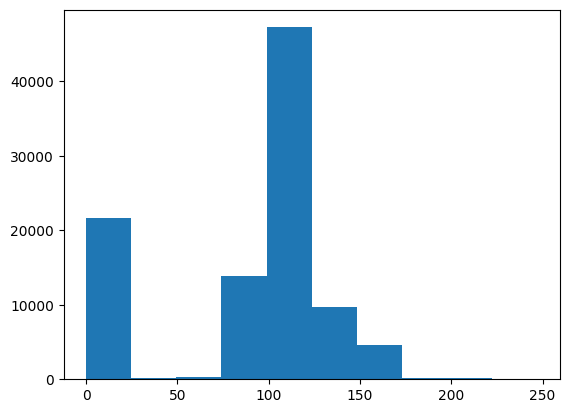

In [31]:
# Visualize pixel values of L channel
im_flat = l.flatten()
plt.hist(im_flat)

(array([21907.,  2187.,  5714., 11916., 19089., 16814., 11374.,  5664.,
         2551.,   615.]),
 array([  4. ,  29.1,  54.2,  79.3, 104.4, 129.5, 154.6, 179.7, 204.8,
        229.9, 255. ]),
 <BarContainer object of 10 artists>)

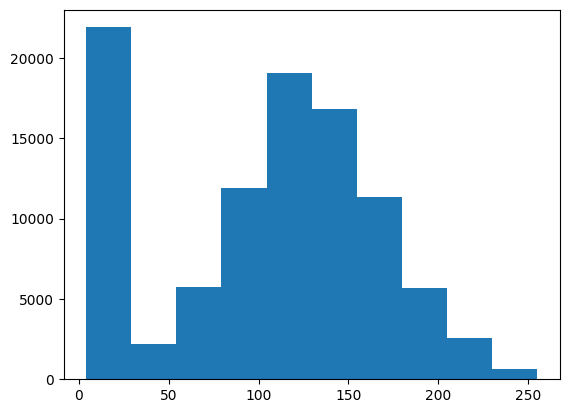

In [32]:
# Apply Contrast limited adaptive histogram equalization(CLAHE)
clahe = cv2.createCLAHE(clipLimit=8.0,tileGridSize=(8,8))
new_l = clahe.apply(l)
plt.hist(new_l.flatten())

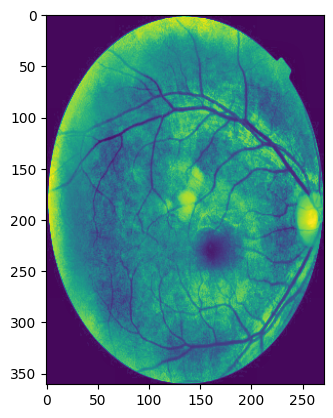

In [33]:
plt.imshow(new_l)

(361, 271, 3)


Text(0.5, 1.0, 'Cropped Image + CLAHE')

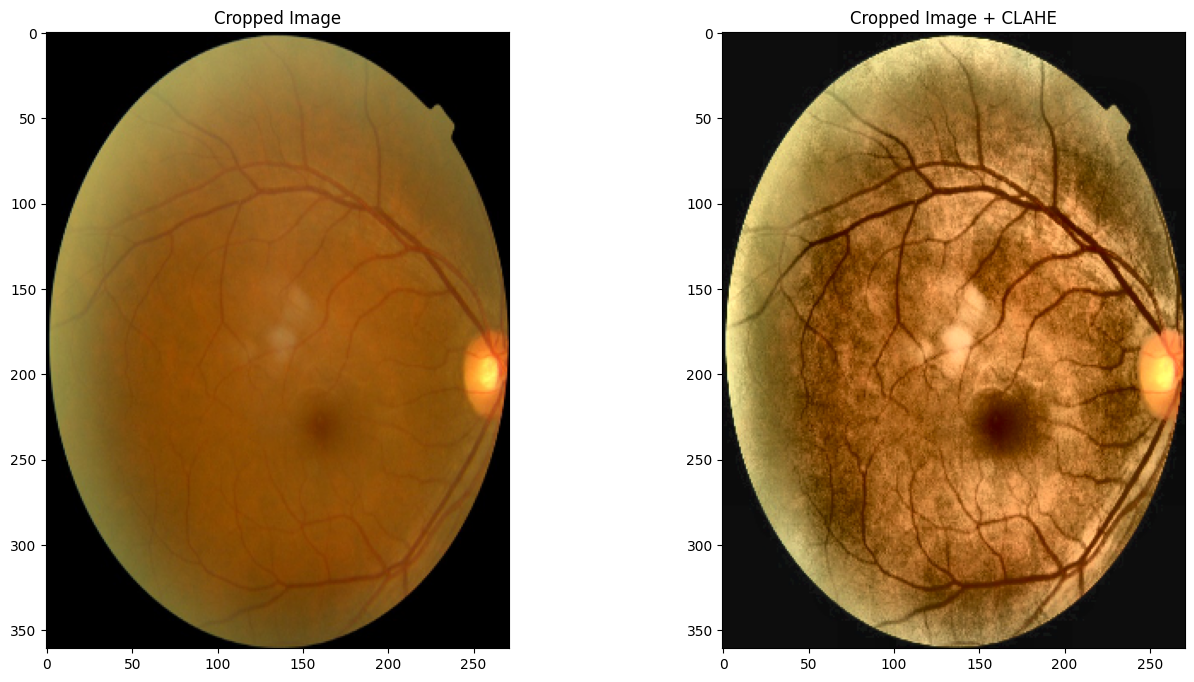

In [34]:
# Merge channels
im_clahe = cv2.merge((new_l,a,b))
im_clahe = cv2.cvtColor(im_clahe,cv2.COLOR_LAB2RGB)
print(im_clahe.shape)

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(crop_im)
plt.title("Cropped Image")

plt.subplot(1,2,2)
plt.imshow(im_clahe)
plt.title("Cropped Image + CLAHE")

## 7 - Median Blur, addWeighted,bitwise

**To clear noises from the image,we will use Median Blur.**

**To detect the bloody areas,we will apply mask by using addWeighted and bitwise operators.**

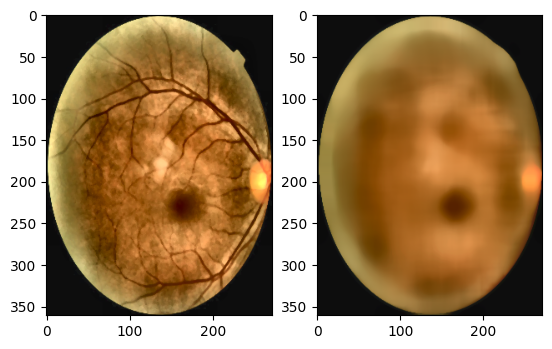

In [35]:
im_median_blur = cv2.medianBlur(im_clahe,3)
high_median_blur = cv2.medianBlur(im_clahe,29)

plt.subplot(1,2,1)
plt.imshow(im_median_blur)

plt.subplot(1,2,2)
plt.imshow(high_median_blur)

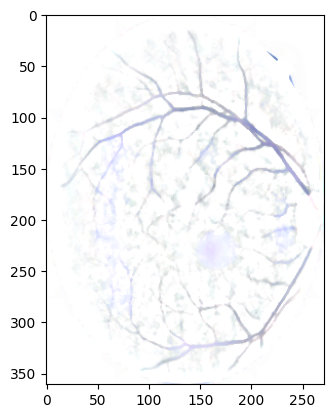

In [36]:
mask = cv2.addWeighted(im_median_blur,1,high_median_blur,-1,255)
plt.imshow(mask)

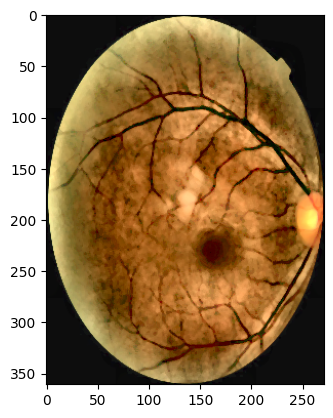

In [37]:
masked_im = cv2.bitwise_and(mask,im_median_blur)
plt.imshow(masked_im)

# Apply processes to all images

In [38]:
from tqdm import tqdm_notebook as tqdm

def process_img(images):
    # Preprocessed images
    images_processed = []

    for im in tqdm(images):
        # Copying image
        img = im.copy()
        # Resizing image
        img = cv2.resize(img,(400,400))
        # Converting image to gray scale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Applying Gaussian Blur
        blur = cv2.GaussianBlur(gray,(5,5),0)
        # Applying thresh to image
        _,thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)
        # Find contours
        contours = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        # Distinguish from tuple
        contours = contours[0][0]
        # Reduce the dimension of contours array
        contours = contours[:,0,:]

        # Find boundary coordinates
        x_coords = contours[:,0]
        y_coords = contours[:,1]
        # Find x_max
        x_max_idx = x_coords.argmax()
        x_max = (x_coords[x_max_idx],y_coords[x_max_idx])
        # Find x_min
        x_min_idx = x_coords.argmin()
        x_min = (x_coords[x_min_idx],y_coords[x_min_idx])
        # Find y_max
        y_max_idx = y_coords.argmax()
        y_max = (x_coords[y_max_idx],y_coords[y_max_idx])
        # Find y_min
        y_min_idx = y_coords.argmin()
        y_min = (x_coords[y_min_idx],y_coords[y_min_idx])

        if x_max[0]-x_min[0]>100 and y_max[1]-y_min[1]>100:
            # Cropping the image
            img_cropped = img[y_min[1]:y_max[1],x_min[0]:x_max[0]]
            # Resizing the image
            img_resized = cv2.resize(img_cropped,(400,400))
        # Converting RGB to LAB
        lab = cv2.cvtColor(img_resized,cv2.COLOR_RGB2LAB)
        # Splitting channels of image
        l,a,b = cv2.split(lab)
        # Creating CLAHE function
        clahe = cv2.createCLAHE(clipLimit = 6.0,tileGridSize=(8,8))
        # Applying CLAHE function to image
        new_l = clahe.apply(l)
        # Merging image channels with new L channel
        img_clahe = cv2.merge((new_l,a,b))
        # Convert LAB to RGB
        img_clahe = cv2.cvtColor(img_clahe,cv2.COLOR_LAB2RGB)
        # Applying Median Blur to clear noises
        img_median_blur = cv2.medianBlur(img_clahe,3)
        background = cv2.medianBlur(img_clahe,29)
        # Creating mask to detect bloody areas 
        mask = cv2.addWeighted(img_median_blur,1,background,-1,255)
        # Bitwise image(Black and White = Black,White and White = White)
        img_bitwised = cv2.bitwise_and(mask,img_median_blur)
        # Append processed images to list
        images_processed.append(img_bitwised)
    
    images_processed = np.array(images_processed,dtype = np.uint8)
    return images_processed
    

In [39]:
TRAIN_IMG_PR = process_img(TRAIN_IMAGES)

  0%|          | 0/1200 [00:00<?, ?it/s]

# Visualize processed images

In [40]:
import random

def display_processed_instances(images_processed,paths,df,classes,row,col):
    plt.figure(figsize=(14,12))
    size = row*col
    images = []
    rand_paths = []
    rand_nums = np.random.randint(low=0,high=len(paths)-1,size=size)
    
    for i in rand_nums:    # dataframe and dataset ordered,no problem.
        p = paths[i]
        rand_paths.append(p)
        images.append(images_processed[i])
    for i in range(size):
        
        id_code = rand_paths[i].split(".")[0][-12:]
        label_num = df['diagnosis'][df['id_code']==id_code].iloc[0]
        label = classes[label_num]
        
        plt.subplot(row,col,i+1)
        
        img = images[i]
        
        
        plt.imshow(img)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        

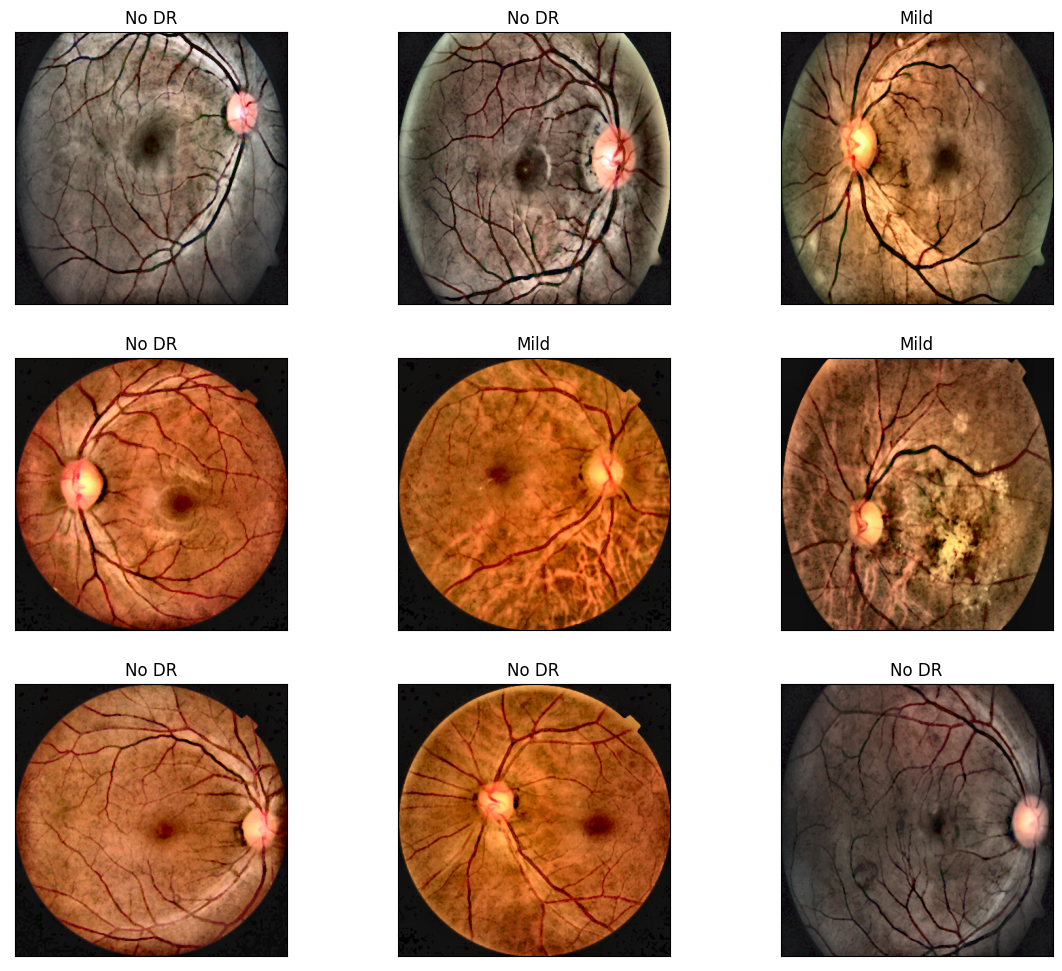

In [41]:
display_processed_instances(TRAIN_IMG_PR,TRAIN_IMG_PATHS,df_train,CLASSES,3,3)

# Multi-label classification

In [42]:
y_train_onehot = pd.get_dummies(df_train['diagnosis']).values
print(y_train_onehot.shape)
y_train_onehot

(1200, 5)


array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

**A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:**

**0 - Low DR [1 0 0 0 0]**

**1 - Medium DR [1 1 0 0 0]**

**2 - High DR [1 1 1 0 0]**

**3 - Severe DR [1 1 1 1 0]**

**4 - Proliferative DR [1 1 1 1 1]**

In [43]:
y_train = np.ones(y_train_onehot.shape,dtype=np.uint8)
y_train

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [44]:
y_train[:,4] = y_train_onehot[:,4]
y_train

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0]], dtype=uint8)

In [45]:
for i in range(3,-1,-1):
    y_train[:,i] = np.logical_or(y_train_onehot[:,i],y_train[:,i+1])
    

In [46]:
y_train_onehot

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [47]:
y_train

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

# Splitting train and test

In [48]:
X_train = TRAIN_IMG_PR
print(X_train.shape)
print(y_train.shape)

(1200, 400, 400, 3)
(1200, 5)


In [49]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,
                                                test_size=0.2,
                                                random_state=33,
                                                shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(960, 400, 400, 3)
(960, 5)
(240, 400, 400, 3)
(240, 5)


# Data augmentation

In [50]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

data_generator = datagen.flow(X_train,y_train,
                          batch_size=4,seed=33)

In [51]:
im,lbl = next(data_generator)
print(im.shape)
print(lbl.shape)

(4, 400, 400, 3)
(4, 5)


# Building model

In [52]:
# Install EfficientNetB5 Package
!pip install efficientnet

In [53]:
from efficientnet.keras import EfficientNetB5

# Create model
model_ex = EfficientNetB5()
# Summary model
model_ex.summary()
len(model_ex.layers)

Model: "efficientnet-b5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 228, 228, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 228, 228, 48  192         ['stem_conv[0][0]']              
                                )                                                   

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 24)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 6)      150         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 24)     168         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

                                                                                                  
 block2b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2b_se_reshape[0][0]']     
                                                                                                  
 block2b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2b_se_reduce[0][0]']      
                                                                                                  
 block2b_se_excite (Multiply)   (None, 114, 114, 24  0           ['block2b_activation[0][0]',     
                                0)                                'block2b_se_expand[0][0]']      
                                                                                                  
 block2b_project_conv (Conv2D)  (None, 114, 114, 40  9600        ['block2b_se_excite[0][0]']      
                                )                                                                 
          

 block2d_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2d_se_squeeze[0][0]']     
                                                                                                  
 block2d_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2d_se_reshape[0][0]']     
                                                                                                  
 block2d_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2d_se_reduce[0][0]']      
                                                                                                  
 block2d_se_excite (Multiply)   (None, 114, 114, 24  0           ['block2d_activation[0][0]',     
                                0)                                'block2d_se_expand[0][0]']      
                                                                                                  
 block2d_project_conv (Conv2D)  (None, 114, 114, 40  9600        ['block2d_se_excite[0][0]']      
          

                                                                                                  
 block3a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 57, 57, 240)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_p

 block3c_project_conv (Conv2D)  (None, 57, 57, 64)   24576       ['block3c_se_excite[0][0]']      
                                                                                                  
 block3c_project_bn (BatchNorma  (None, 57, 57, 64)  256         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 57, 57, 64)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 57, 57, 64)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_e

 block3e_drop (FixedDropout)    (None, 57, 57, 64)   0           ['block3e_project_bn[0][0]']     
                                                                                                  
 block3e_add (Add)              (None, 57, 57, 64)   0           ['block3e_drop[0][0]',           
                                                                  'block3d_add[0][0]']            
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 57, 57, 384)  24576       ['block3e_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 57, 57, 384)  1536       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_e

 block4c_expand_activation (Act  (None, 29, 29, 768)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, 29, 29, 768)  6912       ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 29, 29, 768)  3072       ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 29, 29, 768)  0          ['block4c_bn[0][0]']             
 )        

                                                                                                  
 block4e_bn (BatchNormalization  (None, 29, 29, 768)  3072       ['block4e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4e_activation (Activation  (None, 29, 29, 768)  0          ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 768)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_s

 )                                                                                                
                                                                                                  
 block4g_se_squeeze (GlobalAver  (None, 768)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 32)     24608       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4g_se_reduce[0][0]']      
          

 block5b_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 29, 29, 1056  0           ['block5b_activation[0][0]',     
                                )                                 'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 29, 29, 176)  185856      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 29, 29, 176)  704        ['block5b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_d

                                )                                 'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 29, 29, 176)  185856      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 29, 29, 176)  704        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 29, 29, 176)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 29, 29, 176)  0           ['block5d_drop[0][0]',           
          

                                                                                                  
 block5f_project_bn (BatchNorma  (None, 29, 29, 176)  704        ['block5f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5f_drop (FixedDropout)    (None, 29, 29, 176)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 29, 29, 176)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block5g_expand_conv (Conv2D)   (None, 29, 29, 1056  185856      ['block5f_add[0][0]']            
          

                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 15, 15, 1824  554496      ['block6a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 15, 15, 1824  7296       ['block6b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6b_expand_activation (Act  (None, 15, 15, 1824  0          ['block6b_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6b_d

                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 15, 15, 1824  7296       ['block6d_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6d_expand_activation (Act  (None, 15, 15, 1824  0          ['block6d_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 15, 15, 1824  45600      ['block6d_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6d_b

                                                                                                  
 block6f_expand_activation (Act  (None, 15, 15, 1824  0          ['block6f_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6f_dwconv (DepthwiseConv2  (None, 15, 15, 1824  45600      ['block6f_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6f_bn (BatchNormalization  (None, 15, 15, 1824  7296       ['block6f_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6f_a

                                                                                                  
 block6h_dwconv (DepthwiseConv2  (None, 15, 15, 1824  45600      ['block6h_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 15, 15, 1824  7296       ['block6h_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6h_activation (Activation  (None, 15, 15, 1824  0          ['block6h_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6h_s

                                                                                                  
 block7a_bn (BatchNormalization  (None, 15, 15, 1824  7296       ['block7a_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block7a_activation (Activation  (None, 15, 15, 1824  0          ['block7a_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1824)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_s

 agePooling2D)                                                                                    
                                                                                                  
 block7c_se_reshape (Reshape)   (None, 1, 1, 3072)   0           ['block7c_se_squeeze[0][0]']     
                                                                                                  
 block7c_se_reduce (Conv2D)     (None, 1, 1, 128)    393344      ['block7c_se_reshape[0][0]']     
                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3072)   396288      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 15, 15, 3072  0           ['block7c_activation[0][0]',     
                                )                                 'block7c_se_expand[0][0]']      
          

572

In [54]:
# include_top=False --> Remove fully connected layers(last 3 layers our model)
model_ex2 = EfficientNetB5(include_top=False)
len(model_ex2.layers)

569

In [55]:
len(model_ex.layers),len(model_ex2.layers)

(572, 569)

In [56]:
model = tf.keras.models.Sequential()

model.add(EfficientNetB5(weights='imagenet',include_top = False,
                         input_shape=(400,400,3)))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=5,activation='sigmoid'))

print(len(model.layers))


4


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 13, 13, 2048)     28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


# Setting optimizer and loss function

In [58]:
LR = 1e-4
EPOCHS = 5
LOSS = tf.keras.losses.binary_crossentropy
BATCH_SIZE = 4

In [59]:
from keras.optimizers import Adam
# Choosing Adam optimizer
optimizer = Adam(lr=LR)
# Compiling the model
model.compile(loss=LOSS,optimizer=optimizer,metrics=['accuracy'])

# Callbacks

In [63]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

# Reducing learning rate with some parameters
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              factor=0.1,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=0)
# Saving best weights for model
folder = './saved_model'
# Check whether the specified path exists or not
isExist = os.path.exists(folder)
#printing if the path exists or not
if isExist==False:
    os.mkdir(folder)
filepath = './saved_model/blindless-detection-best-weights-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            save_weigths_only=True)

callbacks = [reduce_lr,checkpoint]



In [64]:
with tf.device('/CPU:0'):
    history = model.fit(data_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=len(X_train)//BATCH_SIZE,
                        validation_data=(X_test[:400],y_test[:400]))

Epoch 1/5
240/240 [==============================] - 2017s 8s/step - loss: 0.3730 - accuracy: 0.8625 - val_loss: 0.2174 - val_accuracy: 0.8708
Epoch 2/5
240/240 [==============================] - 1969s 8s/step - loss: 0.2733 - accuracy: 0.9750 - val_loss: 0.1936 - val_accuracy: 0.9625
Epoch 3/5
240/240 [==============================] - 1971s 8s/step - loss: 0.2497 - accuracy: 0.9771 - val_loss: 0.1691 - val_accuracy: 1.0000
Epoch 4/5
240/240 [==============================] - 1975s 8s/step - loss: 0.2389 - accuracy: 0.9937 - val_loss: 0.1724 - val_accuracy: 1.0000
Epoch 5/5
240/240 [==============================] - 1963s 8s/step - loss: 0.2043 - accuracy: 0.9875 - val_loss: 0.1880 - val_accuracy: 0.9958


# Visualizing the results

Text(0.5, 1.0, 'Accuracy')

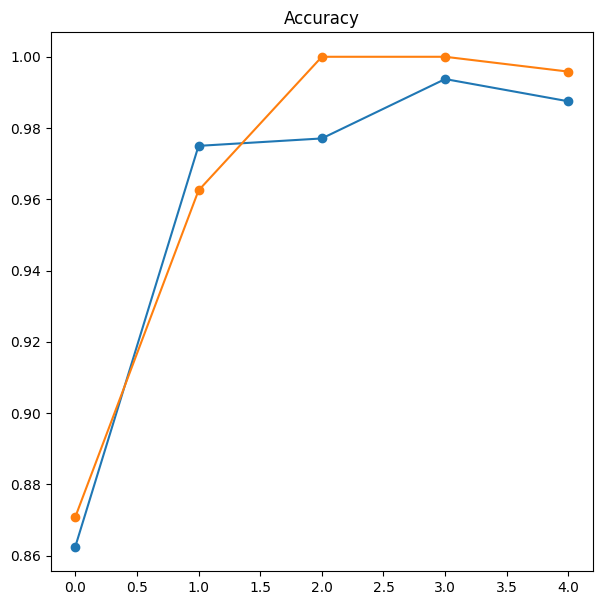

In [71]:
# Get accuracy and loss results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7,7))

# Plot accuracy results for each epochs
plt.plot(acc,marker='o')
plt.plot(val_acc,marker='o')
plt.title("Accuracy")

Text(0.5, 1.0, 'Accuracy')

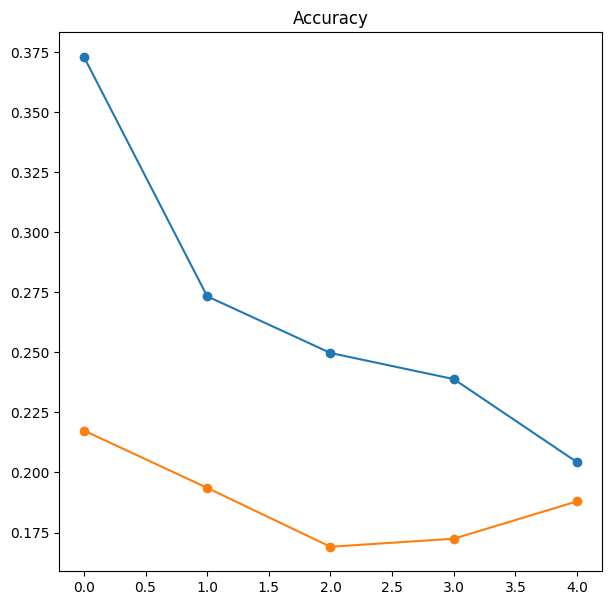

In [135]:
# Plot loss results for each epochs
plt.figure(figsize=(7,7))
plt.plot(loss,marker='o')
plt.plot(val_loss,marker='o')
plt.title("Accuracy")

# Saving the model

In [65]:
# Save the model
model.save('blindless_detection_model.h5')

# Save weights only
model.save_weights('blindless_detection_weights.h5')

# Prediction on one sample

In [86]:
im = X_train[77]
im_expand = np.expand_dims(im,axis=0)
pred_im = model.predict(im_expand)
pred_im=pred_im[0]
pred_im

1/1 [==============================] - 0s 37ms/step


array([0.9996642 , 0.61268395, 0.13059945, 0.00227434, 0.00143663],
      dtype=float32)

In [87]:
pred_im.shape

(5,)

In [89]:
pred_im = np.where(pred_im>0.5, 1, 0)
pred_im  # --> Medium DR

array([1, 1, 0, 0, 0])

# Visualizing the prediction

In [101]:
def visualize_predictions(images_processed,paths,df,classes,row,col):
    plt.figure(figsize=(14,12))
    size = row*col
    images = []
    rand_paths = []
    rand_nums = np.random.randint(low=0,high=len(paths)-1,size=size)
    
    for i in rand_nums:    # dataframe and dataset ordered,no problem.
        p = paths[i]
        rand_paths.append(p)
        images.append(images_processed[i])
    for i in range(size):
        
        id_code = rand_paths[i].split(".")[0][-12:]
        label_num = df['diagnosis'][df['id_code']==id_code].iloc[0]
        label = classes[label_num]

        plt.subplot(row,col,i+1)
        
        img = images[i]
        
        # Converting image to four dimension 
        img_expand = np.expand_dims(img,axis=0)
        pred = model.predict(img_expand)
        # Reducing dimension(1,5) to (5,)
        pred = pred[0]
        # If prediction>0.5,go to 1,else 0
        pred = np.where(pred>0.5,1,0)
        
        # Showing the image
        plt.imshow(img)
        plt.title(f"{label_num}:{label}\n {pred}")
        plt.xticks([])
        plt.yticks([])
        

1/1 [==============================] - 0s 31ms/step


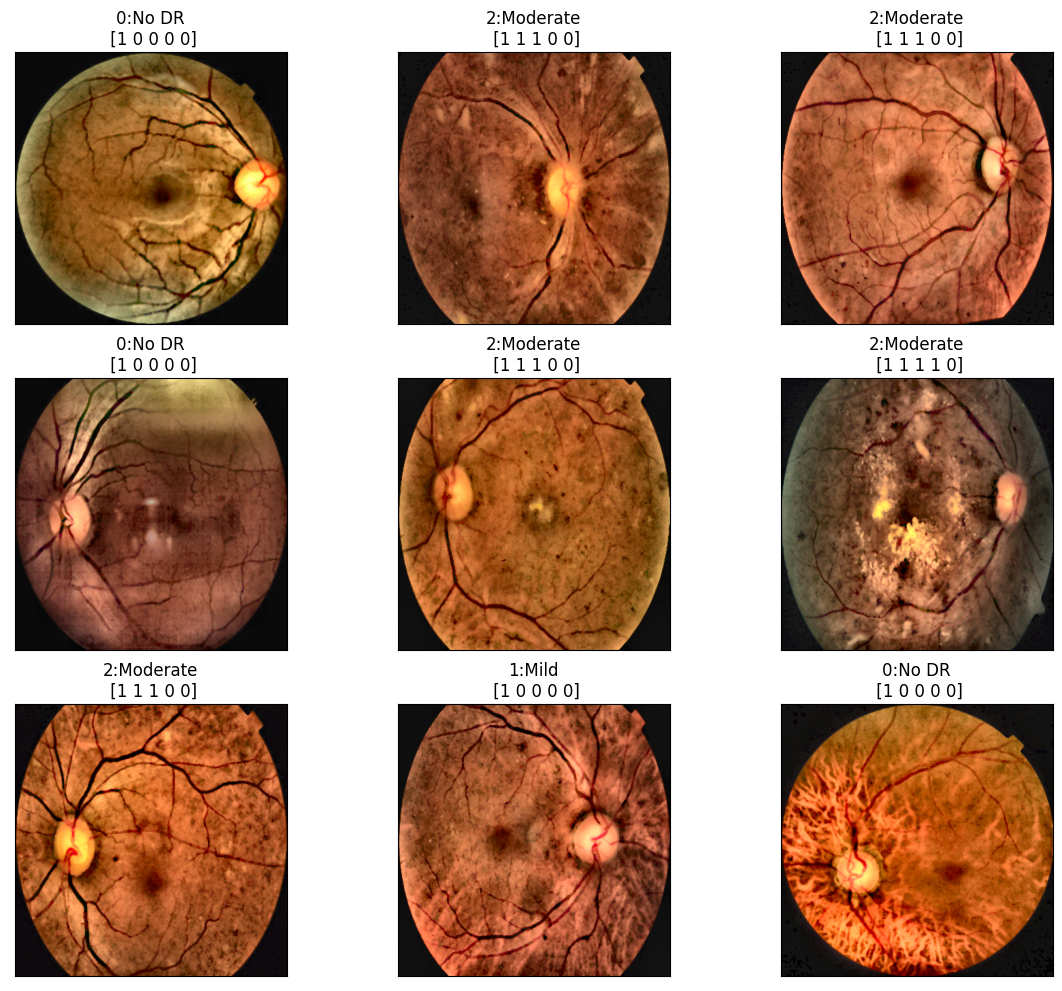

In [102]:
visualize_predictions(TRAIN_IMG_PR,TRAIN_IMG_PATHS,df_train,CLASSES,3,3)

In [133]:
# Number of true prediction on train dataset
num_acc = int(len(X_train)*acc[-1])
print(f"{num_acc}/{len(X_train)} correct prediction on train dataset")

948/960 correct prediction on train dataset


In [134]:
# Number of true prediction on test dataset
num_acc = int(len(X_test)*val_acc[-1])
print(f"{num_acc}/{len(X_test)} correct prediction on train dataset")

239/240 correct prediction on train dataset
